# **Data Science Practical Test**
## Instructions
Analyse and use a machine learning model with the Amazon Kindle reviews data provided. You may decide what to do with the data as long as the following criterias are met:


1. Define the aim of the project
2. Use a machine learning model
3. Assess the quality of the model with appropriate metric(s)
4. Use any visualisation as appropriate
5. Write succinct documentation
6. Explain your thought process/justify your decisions
7. All work, including any pre-processing, must be done in this notebook
8. Must use Python


## Rules
* Email completed project to leo.mooney@partly.com, joana@partly.com and cc dan@partly.com
* Any submission after the deadline will be discounted
* Copying from any existing project is not allowed




# Data
Download the data here: https://drive.google.com/file/d/1bXotNR-Rwvlim89LZkii62wS4HKm2ceX/view?usp=sharing

The provided data is a sample of 982,619 reviews from the Amazon Kindle store.

Columns:
* `reviewerID` - ID of the reviewer, e.g. A2SUAM1J3GNN3B
* `asin` - ID of the product, e.g. 0000013714
* `reviewerName` - name of the reviewer
* `helpful` - helpfulness rating of the review, format: [number of positive helpfulness ratings, total number of helpfulness ratings]. i.e. [2, 3] means 3 people rated the review, 2 people found it helpful and 1 found it unhelpful.
* `reviewText` - text of the review
* `overall` - rating of the product
* `summary` - summary of the review
* `unixReviewTime` - time of the review (unix time)
* `reviewTime` - time of the review (raw)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.utils import resample
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

In [2]:
# Load the dataset from CSV
file_path = 'C:/Users/sumee/Downloads/review_Kindle_Store.csv' 
data = pd.read_csv(file_path)

In [3]:
data.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1F6404F1VG29J,B000F83SZQ,Avidreader,"[0, 0]",I enjoy vintage books and movies so I enjoyed ...,5.0,Nice vintage story,1399248000,"05 5, 2014"
1,AN0N05A9LIJEQ,B000F83SZQ,critters,"[2, 2]",This book is a reissue of an old one; the auth...,4.0,Different...,1388966400,"01 6, 2014"
2,A795DMNCJILA6,B000F83SZQ,dot,"[2, 2]",This was a fairly interesting read. It had ol...,4.0,Oldie,1396569600,"04 4, 2014"
3,A1FV0SX13TWVXQ,B000F83SZQ,"Elaine H. Turley ""Montana Songbird""","[1, 1]",I'd never read any of the Amy Brewster mysteri...,5.0,I really liked it.,1392768000,"02 19, 2014"
4,A3SPTOKDG7WBLN,B000F83SZQ,Father Dowling Fan,"[0, 1]","If you like period pieces - clothing, lingo, y...",4.0,Period Mystery,1395187200,"03 19, 2014"


performing EDA 

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 982619 entries, 0 to 982618
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   reviewerID      982619 non-null  object 
 1   asin            982619 non-null  object 
 2   reviewerName    978797 non-null  object 
 3   helpful         982619 non-null  object 
 4   reviewText      982597 non-null  object 
 5   overall         982619 non-null  float64
 6   summary         982500 non-null  object 
 7   unixReviewTime  982619 non-null  int64  
 8   reviewTime      982619 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 67.5+ MB


In [5]:
## missing value 
data.isnull().sum()

reviewerID           0
asin                 0
reviewerName      3822
helpful              0
reviewText          22
overall              0
summary            119
unixReviewTime       0
reviewTime           0
dtype: int64

In [6]:
data.shape

(982619, 9)

In [7]:
# Converting object columns to categorical types columns
cols = data.select_dtypes(include=['object']).columns
for i in cols:
    data[i] = data[i].astype('category')

In [8]:
# getting distinct counts for categorical columns
for i in cols:
    print(f"Unique values in '{i}': {data[i].nunique()}")

Unique values in 'reviewerID': 68223
Unique values in 'asin': 61934
Unique values in 'reviewerName': 55476
Unique values in 'helpful': 1494
Unique values in 'reviewText': 982267
Unique values in 'summary': 623239
Unique values in 'reviewTime': 2117


In [9]:
# convert the unixReviewTime to datetime format
data['review_date'] = pd.to_datetime(data['unixReviewTime'], unit='s')

# extract year, month, and day of the week
data['review_year'] = data['review_date'].dt.year
data['review_month'] = data['review_date'].dt.month
data['review_day_of_week'] = data['review_date'].dt.dayofweek  # Monday=0, Sunday=6

In [10]:
data.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,review_date,review_year,review_month,review_day_of_week
0,A1F6404F1VG29J,B000F83SZQ,Avidreader,"[0, 0]",I enjoy vintage books and movies so I enjoyed ...,5.0,Nice vintage story,1399248000,"05 5, 2014",2014-05-05,2014,5,0
1,AN0N05A9LIJEQ,B000F83SZQ,critters,"[2, 2]",This book is a reissue of an old one; the auth...,4.0,Different...,1388966400,"01 6, 2014",2014-01-06,2014,1,0
2,A795DMNCJILA6,B000F83SZQ,dot,"[2, 2]",This was a fairly interesting read. It had ol...,4.0,Oldie,1396569600,"04 4, 2014",2014-04-04,2014,4,4
3,A1FV0SX13TWVXQ,B000F83SZQ,"Elaine H. Turley ""Montana Songbird""","[1, 1]",I'd never read any of the Amy Brewster mysteri...,5.0,I really liked it.,1392768000,"02 19, 2014",2014-02-19,2014,2,2
4,A3SPTOKDG7WBLN,B000F83SZQ,Father Dowling Fan,"[0, 1]","If you like period pieces - clothing, lingo, y...",4.0,Period Mystery,1395187200,"03 19, 2014",2014-03-19,2014,3,2


In [11]:
# the top 10 products based on review count
top_products = data['asin'].value_counts().nlargest(10).reset_index()

In [12]:
top_products

,asin,count
0,B006GWO5WK,1113
1,B00BTIDW4S,781
2,B00BT0J8ZS,516
3,B00JDYC5OI,502
4,B00H0V069M,481
5,B00BTIDXVU,454
6,B00BSX4U04,452
7,B00BTIDOO6,428
8,B007R5YDYA,422
9,B005DOK8NW,408


In [13]:
top_products.columns = ['asin', 'review_count']

In [14]:
top_products.columns

Index(['asin', 'review_count'], dtype='object')

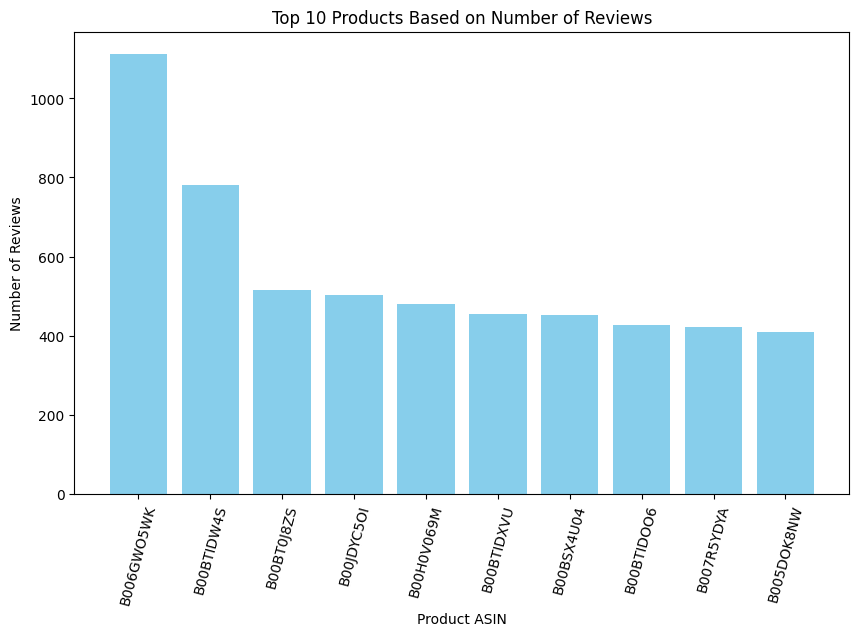

In [15]:
# Plotting top 10 products based on review count
plt.style.use('fast')
plt.figure(figsize=(10, 6))
plt.bar(top_products['asin'], top_products['review_count'], color='skyblue')
plt.xticks(rotation=75)
plt.xlabel('Product ASIN')
plt.ylabel('Number of Reviews')
plt.title('Top 10 Products Based on Number of Reviews')
plt.show()

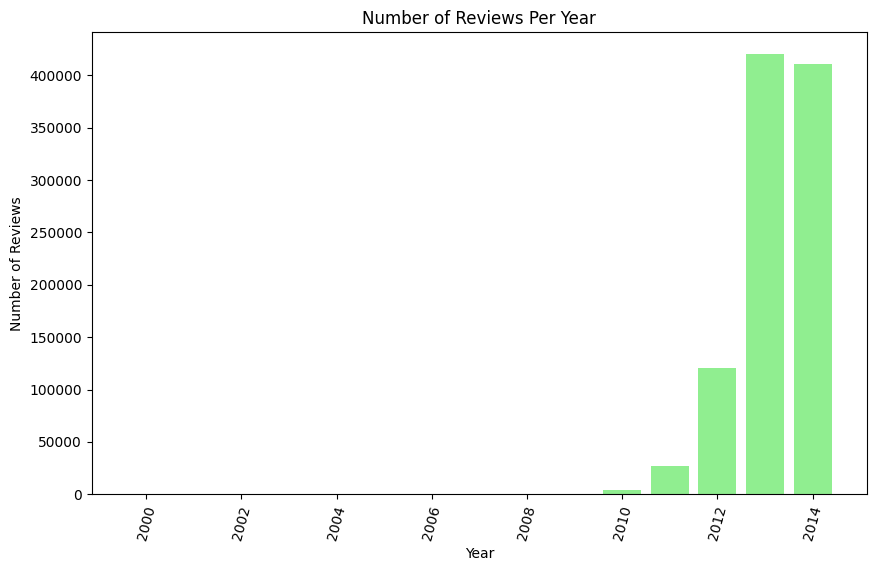

In [16]:
# Group data by review year and get the count of reviews per year
reviews_per_year = data['review_year'].value_counts().reset_index()
reviews_per_year.columns = ['review_year', 'review_count']

# Sorting the data by year
reviews_per_year = reviews_per_year.sort_values('review_year')

# Plotting the number of reviews per year
plt.style.use('fast')
plt.figure(figsize=(10, 6))
plt.bar(reviews_per_year['review_year'], reviews_per_year['review_count'], color='lightgreen')
plt.xticks(rotation=75)
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews Per Year')
plt.show()

In [17]:
reviews_per_year #2013 has highest review

,review_year,review_count
11,2000,8
13,2001,2
14,2002,1
12,2003,4
10,2004,10
9,2005,18
8,2006,23
7,2007,39
6,2008,191
5,2009,512


In [18]:
#checking target variable 
data.overall.value_counts()

overall
5.0    575264
4.0    254013
3.0     96194
2.0     34130
1.0     23018
Name: count, dtype: int64

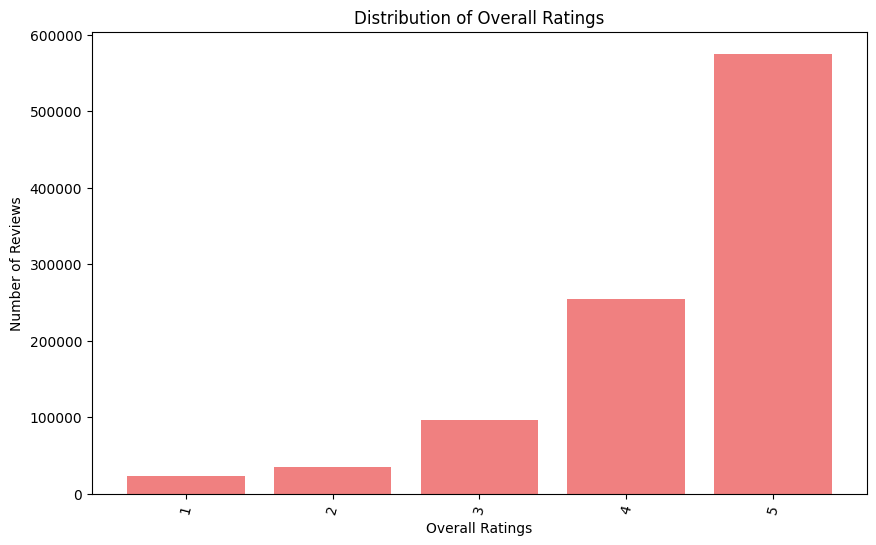

In [19]:
# Group data by overall ratings and get the count of each rating
rating_counts = data['overall'].value_counts().reset_index()
rating_counts.columns = ['rating', 'count']

# Sorting the data by ratings
rating_counts = rating_counts.sort_values('rating')

# Plotting the ratings and their counts
plt.style.use('fast')
plt.figure(figsize=(10, 6))
plt.bar(rating_counts['rating'], rating_counts['count'], color='lightcoral')
plt.xticks(rotation=75)
plt.xlabel('Overall Ratings')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Overall Ratings')
plt.show()

This project aims to create a model that can correctly classify customer reviews(positive, neutral and negative) into the sentiment categories i have defined. The goal is to get good accuracy while keeping the model efficient which is achieved with certain settings (hyperparameters), model should generalize on unseen data using boosting method

In [20]:


# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')


# Initialize the Lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to clean the text
def preprocess_text(text):
    # Removing punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Removing non-alphabetical characters
    text = ' '.join(word for word in text.split() if word.isalpha())
    
    # Converting to lowercase
    text = text.lower()
    
    # Remove stopwords
    text = ' '.join(word for word in text.split() if word not in stop_words)
    
    # Lemmatize the words
    text = ' '.join(lemmatizer.lemmatize(word, pos='v') for word in text.split())
    
    return text

# Apply the preprocessing function to the reviewText column
data['cleaned_reviewText'] = data['reviewText'].apply(preprocess_text)

# Display the cleaned text
print(data[['reviewText', 'cleaned_reviewText']].head())



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sumee\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sumee\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                          reviewText  \
0  I enjoy vintage books and movies so I enjoyed ...   
1  This book is a reissue of an old one; the auth...   
2  This was a fairly interesting read.  It had ol...   
3  I'd never read any of the Amy Brewster mysteri...   
4  If you like period pieces - clothing, lingo, y...   

                                  cleaned_reviewText  
0  enjoy vintage book movies enjoy read book plot...  
1  book reissue old one author bear era say nero ...  
2  fairly interest read old style terminologyi gl...  
3  id never read amy brewster mysteries one reall...  
4  like period piece clothe lingo enjoy mystery a...  


In [21]:
data.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime', 'review_date',
       'review_year', 'review_month', 'review_day_of_week',
       'cleaned_reviewText'],
      dtype='object')

In [22]:
reviews = data[['cleaned_reviewText', 'overall']]

In [23]:
reviews.head()

,cleaned_reviewText,overall
0,enjoy vintage book movies enjoy read book plot...,5.0
1,book reissue old one author bear era say nero ...,4.0
2,fairly interest read old style terminologyi gl...,4.0
3,id never read amy brewster mysteries one reall...,5.0
4,like period piece clothe lingo enjoy mystery a...,4.0


C:\Users\sumee\AppData\Local\Temp\ipykernel_3564\3449866022.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews['sentiment'] = reviews['overall'].apply(label_sentiment)


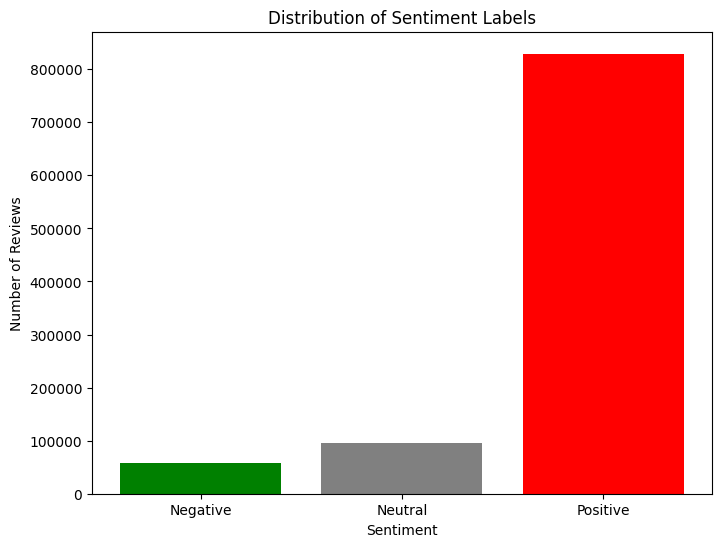

In [24]:

# sentiment labeling function for three groups
def label_sentiment(rating):
    if rating in [4, 5]:
        return 2  # Positive sentiment
    elif rating == 3:
        return 1  # Neutral sentiment
    else:
        return 0  # Negative sentiment

# Apply the sentiment labeling function
reviews['sentiment'] = reviews['overall'].apply(label_sentiment)

# Get the count of each sentiment category
sentiment_counts = reviews['sentiment'].value_counts()

# Plotting with plt only
plt.figure(figsize=(8, 6))
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['red', 'gray', 'green'])

# Labeling the axes and setting the title
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Sentiment Labels')

# Customizing the x-tick labels
plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Neutral', 'Positive'])

# Display the plot
plt.show()


In [25]:
reviews.head()

,cleaned_reviewText,overall,sentiment
0,enjoy vintage book movies enjoy read book plot...,5.0,2
1,book reissue old one author bear era say nero ...,4.0,2
2,fairly interest read old style terminologyi gl...,4.0,2
3,id never read amy brewster mysteries one reall...,5.0,2
4,like period piece clothe lingo enjoy mystery a...,4.0,2


In [26]:
reviews = reviews.dropna(subset=['cleaned_reviewText'])

In [27]:
reviews['overall'].value_counts()

overall
5.0    575246
4.0    254010
3.0     96193
2.0     34130
1.0     23018
Name: count, dtype: int64

In [28]:
reviews['sentiment'].value_counts()

sentiment
2    829256
1     96193
0     57148
Name: count, dtype: int64

In [29]:


# Separate the classes for class balancing 
class_2 = reviews[reviews['sentiment'] == 2]
class_1 = reviews[reviews['sentiment'] == 1]
class_0 = reviews[reviews['sentiment'] == 0]

# Downsample class 2 and class 1 to matches class 0
class_2_downsampled = resample(class_2, replace=False, n_samples=len(class_0), random_state=42) 
class_1_downsampled = resample(class_1, replace=False, n_samples=len(class_0), random_state=42)

# Combine all classes into one balanced DataFrame
balanced_reviews = pd.concat([class_2_downsampled, class_1_downsampled, class_0])



In [30]:
balanced_reviews.head()

,cleaned_reviewText,overall,sentiment
908685,diva still young heart keep let eddie sweet ta...,5.0,2
340066,love read good action romance adore stories se...,5.0,2
772164,quite long time since love series much actuall...,5.0,2
893333,receive book exchange honest reviewi huge fan ...,4.0,2
26080,great book well write couldnt put cant wait se...,5.0,2


In [31]:
# Define the feature (x) and target (y) variables
x = balanced_reviews['cleaned_reviewText']  
y = balanced_reviews['sentiment']

In [32]:
class_1_downsampled.shape

(57148, 3)

In [33]:
class_2_downsampled.head(5)

,cleaned_reviewText,overall,sentiment
908685,diva still young heart keep let eddie sweet ta...,5.0,2
340066,love read good action romance adore stories se...,5.0,2
772164,quite long time since love series much actuall...,5.0,2
893333,receive book exchange honest reviewi huge fan ...,4.0,2
26080,great book well write couldnt put cant wait se...,5.0,2


In [34]:
class_0.shape

(57148, 3)

In [35]:
# slitting the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)


In [36]:


# Define the pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', XGBClassifier())
])

# Define parameter distributions for the search
param_distributions = {
    'tfidf__min_df': [0.001, 0.005],
    'tfidf__max_features': [5000, 10000, 15000, 20000],
    'clf__n_estimators': [50, 100, 150],
    'clf__max_depth': [3, 5, 7],
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(pipeline, param_distributions, n_iter=5, cv=3, scoring='accuracy', random_state=42, n_jobs=-1)

# Fit the search to the data
random_search.fit(x_train, y_train)

# Display the best parameters
print("Best Parameters:", random_search.best_params_)


Best Parameters: {'tfidf__min_df': 0.001, 'tfidf__max_features': 20000, 'clf__n_estimators': 100, 'clf__max_depth': 7}


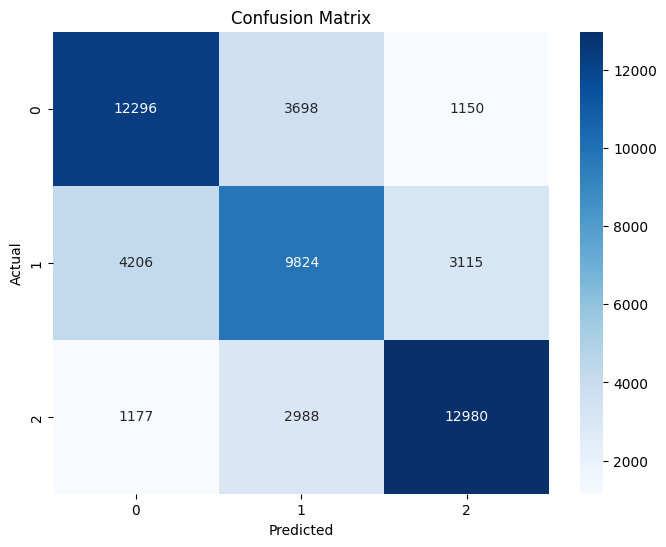

Training Accuracy: 0.7773602199816682
Test Accuracy: 0.6824279659369289
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.72      0.71     17144
           1       0.60      0.57      0.58     17145
           2       0.75      0.76      0.75     17145

    accuracy                           0.68     51434
   macro avg       0.68      0.68      0.68     51434
weighted avg       0.68      0.68      0.68     51434



In [37]:
# predicting on the training and test data
best_model = random_search.best_estimator_
y_train_pred = best_model.predict(x_train)
y_test_pred = best_model.predict(x_test)

# calculate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Confusion matrix for test data
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Display accuracy and classification report
print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print("Classification Report:\n", classification_report(y_test, y_test_pred))

In [38]:
# Vectorize the text using TfidfVectorizer with specified parameters
tfidf = TfidfVectorizer(min_df=0.001, max_features=20000)
X_train_tfidf = tfidf.fit_transform(x_train)
X_test_tfidf = tfidf.transform(x_test)

In [41]:
#  XGBoost model with the above specified parameters
from sklearn.model_selection import  cross_val_score
xgb_model = XGBClassifier(n_estimators=100, max_depth=7, tree_method='hist', random_state=42)

# performing 10-fold instead 5  cross-validation on the training set for accuracy
cv_scores = cross_val_score(xgb_model, X_train_tfidf, y_train, cv=10, scoring='accuracy')

# Train the model on the entire training data after cross-validation
xgb_model.fit(X_train_tfidf, y_train)

# Predict on training and test data
y_train_pred = xgb_model.predict(X_train_tfidf)
y_test_pred = xgb_model.predict(X_test_tfidf)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Confusion matrix for test data
conf_matrix = confusion_matrix(y_test, y_test_pred)

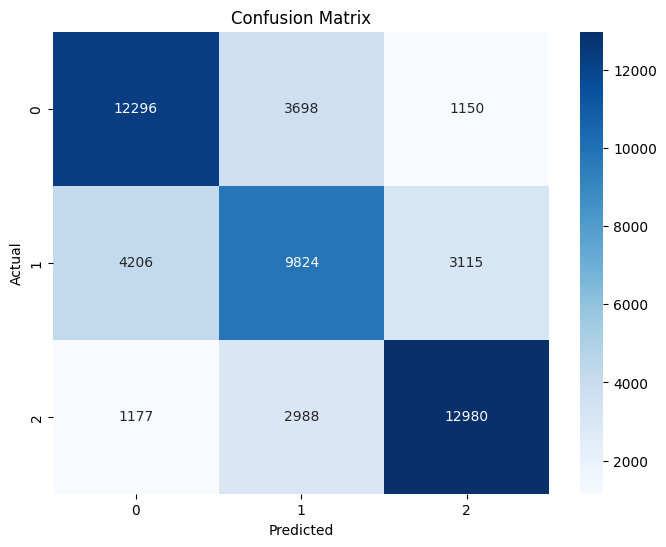

Training Accuracy: 0.7773602199816682
Test Accuracy: 0.6824279659369289
10-Fold Cross-Validation Mean Accuracy: 0.6801599866677777
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.72      0.71     17144
           1       0.60      0.57      0.58     17145
           2       0.75      0.76      0.75     17145

    accuracy                           0.68     51434
   macro avg       0.68      0.68      0.68     51434
weighted avg       0.68      0.68      0.68     51434



In [42]:
# plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Displaying results
print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print("10-Fold Cross-Validation Mean Accuracy:", cv_scores.mean())
print("Classification Report:\n", classification_report(y_test, y_test_pred))

In [ ]:
# Define the XGBoost model not able to execute due to my system low computational power or may be need to re adjust my down sampling technique

##trying to work on this 
xgb_model = XGBClassifier(tree_method='hist', random_state=42)

# Define hyperparameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3]
}

# Perform Randomized Search CV
xgb_cv = RandomizedSearchCV(xgb_model, param_grid, n_iter=10, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
xgb_cv.fit(X_train_tfidf, y_train)

# Extract the best model
best_xgb_model = xgb_cv.best_estimator_

# Fit the model on the full training set
best_xgb_model.fit(X_train_tfidf, y_train)

# Predictions and evaluations
y_train_pred = best_xgb_model.predict(X_train_tfidf)
y_test_pred = best_xgb_model.predict(X_test_tfidf)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)